Rita Ghilardi

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
%matplotlib inline

# Clustering libraries
from sklearn.cluster import KMeans  
from sklearn.cluster import AgglomerativeClustering  
from scipy.cluster.hierarchy import dendrogram, linkage 

# Association Rules libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Recommender Systems libraries
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection import train_test_split 
from surprise.model_selection import cross_validate, GridSearchCV
import io
from collections import defaultdict

# Assignment 2

Welcome to the second assignment! 

You will have to implement clustering, association rules, and recommender systems algorithms, applying these methods to: 
- explore the similarities within groups of people watching movies (clustering analysis)
- discover the relations between movies genre (association rules)
- recommend movies to users (recommender system)

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab.

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

Once you are done you have to submit your notebook here: 
[https://moodle.epfl.ch/mod/assign/view.php?id=1247726](https://moodle.epfl.ch/mod/assign/view.php?id=1247726)

If there is need for further clarifications on the questions, after the assignment is released, we will update this file, so make sure you check the git repository for updates.

Good luck!

## Clustering analysis: similarities between people (10 points)

In this section, you will try to form clusters of individuals based on their preferences regarding movie genres. You will use a transformed version of the MovieLens dataset containing, for a selection of users:
- their average rating of all science fiction movies they rated,
- their average rating of all comedy movies they rated.

Better understanding the differences in people's tastes can help improve the design of recommender systems, for instance for the creation of the user neighborhood. Ok, let's start!

- Load the data in a dataframe. The url link is provided below. Display the first 10 observations.

In [2]:
url_clustering = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ratings_clustering.csv'

# Create DataFrame
df_movies = pd.read_csv(url_clustering)

# Display first 10 rows
df_movies.head(10)

,avg_scifi_rating,avg_comedy_rating
0,3.50,2.71
1,2.56,2.64
2,2.00,3.20
3,3.18,2.83
4,3.00,3.90
5,2.33,3.20
6,3.00,3.63
7,2.30,3.40
8,3.11,3.39
9,2.85,2.47


- Plot a dendogram using "ward" as linkage method and "euclidean" as metric. 
- Based on the dendogram, how many clusters do you think is optimal? Briefly justify your answer.

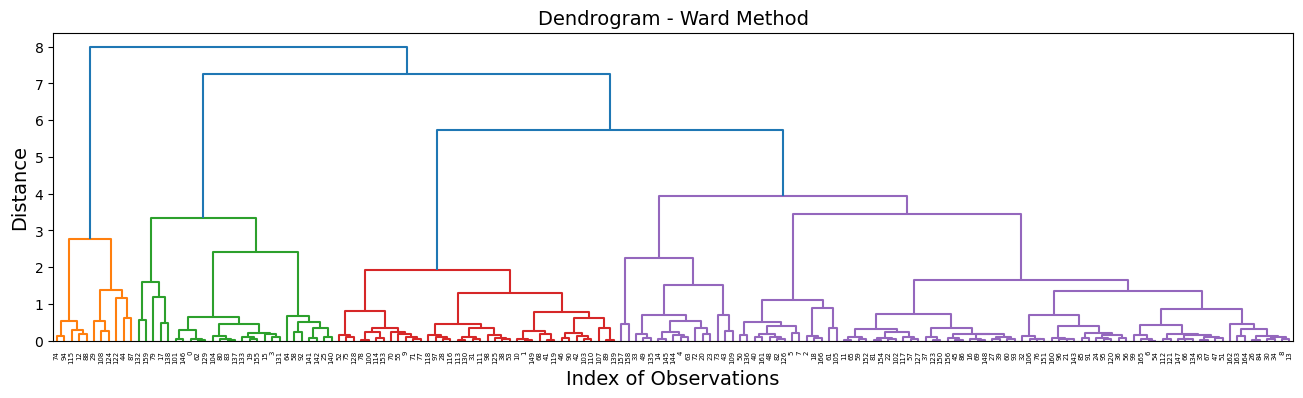

In [3]:
# Define the parameters 
cluster = linkage(df_movies, method = "ward", metric = "euclidean")

# Plot the dendrogram
plt.figure(figsize=(16, 4))
dendrogram(cluster)
plt.title("Dendrogram - Ward Method", fontsize = 14)
plt.xlabel("Index of Observations", fontsize = 14)
plt.ylabel("Distance", fontsize = 14)
plt.show()

By looking at the dendrogram above, it appears that the **optimal number of clusters is 4**. In fact, at a distance of approximately 4.5, the dendrogram shows 4 distinct clusters, which have a relatively large difference in dissimilarity compared to other options. This ensures that the clusters are more **internally homogeneous** and **externally heterogeneous**. In other words, the objects within each cluster are more similar to each other than to the objects in the other clusters. 

It is important to note that one of the resulting clusters (i.e., the purple one) will be **larger than the others**, as it looks to comprise almost half of the observations. This can be due to a larger variation in the data points within that cluster.


- Implement the Elbow method to determine the optimum number of cluster for K-Means algorithm (use `random_state=17` as parameter of K-Means). 
- Based on the Elbow method, how many clusters do you think is optimal? Briefly justify your answer.

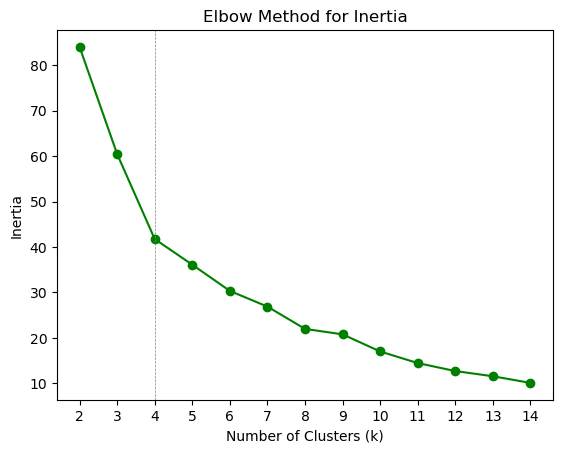

In [4]:
inertias = []            # Initializing empty list to collect inertias
n_clusters = range(2,15) # Clusters from 2 to 14

for i in n_clusters:
    
    # Create and fit model
    km = KMeans(n_clusters = i, random_state = 17, n_init = "auto").fit(df_movies)  
    inertias.append(km.inertia_)     

# Plot      
plt.plot(n_clusters, inertias, '-o', color = "green")
plt.xticks(n_clusters)
plt.title("Elbow Method for Inertia")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.axvline(x = 4, linestyle = "--", color = "grey", linewidth = .5)
plt.show()

The graph above supports the previous choice of **4 clusters**. By looking at the green line, we can observe an "elbow" point at k = 4, suggesting that beyond that point, the inertia does not significantly decrease as it happens for the previous amount of clusters. 

Even though the model would be better at explaining the variation of data points, choosing a higher number could lead to **overfitting**. 

- Implement (train) a K-Means algorithm with the number of clusters of your choice. Use `random_state=17` as parameter.

In [5]:
# Set up the KMeans model specifying the number of clusters = 4 
kmeans_model = KMeans(n_clusters = 4, random_state = 17, n_init='auto') 

# Fit the model
kmeans_model.fit(df_movies)

KMeans(n_clusters=4, n_init='auto', random_state=17)

- Implement (train) a hierarchical algorithm with the same number of clusters as for the K-Means model. Use "ward" as linkage method and "euclidean" as metric/affinity 

In [6]:
# Set up the hierarchical algorithm
agglomerative = AgglomerativeClustering(n_clusters = 4, metric = "euclidean", linkage = "ward")

# Fit the model
agglomerative.fit(df_movies)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

- Create a figure consisting of two subplots:
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your KMeans model. Add the cluster centers to your plot. Label your clusters with the name of your choice (e.g., "Comedy aficionado").
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your hierarchical algorithm model. Label your clusters with the name of your choice.
- How do your models compare?

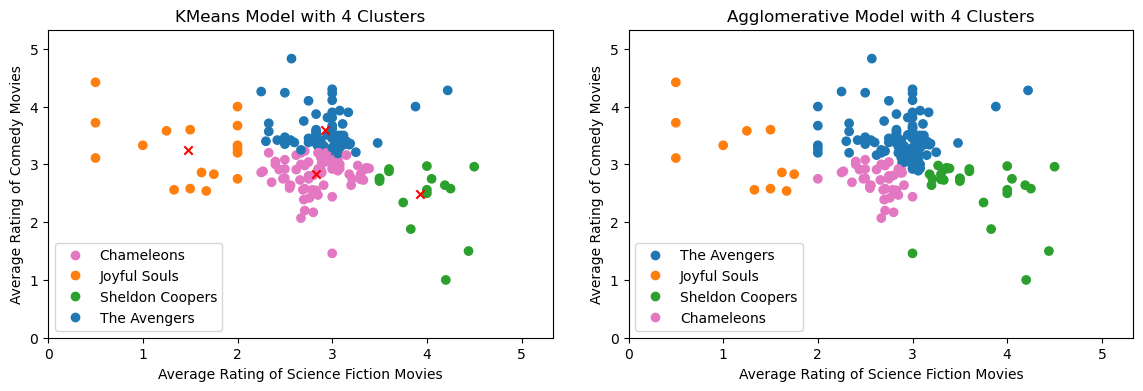

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Scatter plot of clusters, KMeans Model with 4 Clusters
kmeans_scatter = ax[0].scatter(df_movies["avg_scifi_rating"], 
                 df_movies["avg_comedy_rating"], 
                 c = kmeans_model.labels_,                   # Points colored by the clusters
                 cmap = ListedColormap(["tab:pink", "tab:orange", "tab:green", "tab:blue"]))

ax[0].scatter(kmeans_model.cluster_centers_[:, 0],           # X-coordinates of cluster centroids
               kmeans_model.cluster_centers_[:, 1],          # Y-coordinates of cluster centroids
               c = "red",                                    # Color of centroids
               marker = "x")                                 # Marker of centroids
ax[0].set_xlabel("Average Rating of Science Fiction Movies")
ax[0].set_ylabel("Average Rating of Comedy Movies")
ax[0].set_title("KMeans Model with 4 Clusters")
# Set x and y limits
ax[0].set_xlim(left = 0, right = max(df_movies["avg_comedy_rating"]) + 0.5)    
ax[0].set_ylim(bottom = 0, top = max(df_movies["avg_comedy_rating"]) + 0.5)  
# Add legend
ax[0].legend(handles = kmeans_scatter.legend_elements()[0], 
             labels = ["Chameleons", "Joyful Souls", "Sheldon Coopers", "The Avengers"])


# Scatter plot of clusters, agglomerative clustering with 4 Clusters
aggl_scatter = ax[1].scatter(df_movies["avg_scifi_rating"], 
              df_movies["avg_comedy_rating"], 
              c = agglomerative.labels_, cmap = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:pink"])) 

ax[1].set_xlabel("Average Rating of Science Fiction Movies")
ax[1].set_ylabel("Average Rating of Comedy Movies")
ax[1].set_title("Agglomerative Model with 4 Clusters")
# Set x and y limits
ax[1].set_xlim(left = 0, right = max(df_movies["avg_comedy_rating"]) + 0.5)    
ax[1].set_ylim(bottom = 0, top = max(df_movies["avg_comedy_rating"]) + 0.5)  

ax[1].legend(handles = aggl_scatter.legend_elements()[0], 
             labels = ["The Avengers", "Joyful Souls", "Sheldon Coopers", "Chameleons"])


plt.subplots_adjust(wspace = 0.15)   # Space between plots
plt.show()

Overall, the two models seem to cluster data points in a very similar way. However some differences can be observed: 

- **Joyful Souls**: The Agglomerative Model includes a smaller amount of observations in this groups, while the K-Means also captures people having higher science fiction movies rating. In other words, the Agglomerative Model captures the most extreme data points that exhibit high preference towards comedies, and low tolerance to Sci-Fi films.  

- **The Avengers**: This category is characterized by a high comedies rating, and a little lower (but still high) Sci-Fi rating. In the case of the Agglomerative Model, this group seems the most prevalent one, as it includes observations that in the K-Means Model are clustered in the "Joyful Souls" and "Chamaleons". 

- **Sheldon Coopers**: While the Agglomerative Model captured just the most extreme observations for the "Joyful Souls" cluster, while the K-Means included more "central" ones, the pattern seems now to be reversed. In fact, the K-Means Models excludes observations that lie in the conglomerate at the center of the graph, capturing only data points showing high preference towards Sci-Fi movies and low towards comedies. 

- **Chamaleons**: This group is the prevalent one for the K-Means Model, as it comprises observations that in the other model are clustered as "The Avengers", and "Sheldon Coopers". 



## Association Rules: association between movie genres (10 points)

You will now pursue your analysis, but this time trying to dig out information about movies. More precisely, you will search for matches between film genres using association rules. We try to understand, for instance, how likely it is that a film is both drama and action. This information can be interesting for film producers who may either want to produce something similar to the established norm: if most drama films are also action, perhaps the new action-drama film would be equally appreciated, or quite to the contrary try a new combination of genres which is more rare to find.

- Load the data in a dataframe. The url link is provided below. 
- Display the first 10 observations. 
- Print the unique values of genres from the first column. 
- How many unique genres does the first column contain? 
- How many movies does the dataframe contains?

In [8]:
url_association_rules = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/movies_assoc_rules.csv'

# Create DataFrame
df_movie_type = pd.read_csv(url_association_rules)

# Display first 10 rows
display(df_movie_type.head(10))

# Unique genres from first column
print("\n These are the unique values of genres in the first column:\n", df_movie_type.iloc[:,0].unique())

# Number of unique genres from first column
print("\n In the first column there are", len(df_movie_type.iloc[:,0].unique()), "unique genres.")

# Number of movies
print("\n The DataFrame contains", len(df_movie_type), "movies.")

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Action,Crime,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adventure,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Action,Adventure,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 These are the unique values of genres in the first column:
 ['Adventure' 'Comedy' 'Action' 'Drama' 'Crime' 'Children' 'Mystery'
 'Documentary' 'Animation' 'Thriller' 'Horror' 'Fantasy' 'Western'
 'Film-Noir' 'Romance' 'War' 'Sci-Fi' 'Musical' 'IMAX']

 In the first column there are 19 unique genres.

 The DataFrame contains 27032 movies.


- Preprocessing: as seen during the lab, convert the dataset using a `Transaction Encoder` from the `mlextend` module so that the dataset is reorganised in columns of unique genres. Rows should contain only True or False boolean values according to whether a film was considered as belonging to a genre column or not. Check that you have the correct dimensions.

In [9]:
# Convert dataframe to list of list
movie_list = df_movie_type.values.tolist()

# Remove NaNs 
movie_list_cleaned = [[x for x in y if str(x) != "nan"] for y in movie_list]

# Create instance of Encoder
te = TransactionEncoder()

# Fit encoder and transform the DataFrame
movie_list_encoded = te.fit(movie_list_cleaned).transform(movie_list_cleaned)

# Create DataFrame with encoded list
movie_encoded = pd.DataFrame(movie_list_encoded, columns = te.columns_)
display(movie_encoded.head())

# Check the dimensions
len(movie_encoded.columns) == len(df_movie_type.iloc[:,0].unique())

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


True

- Frequent itemsets: using the Apriori algorithm to find the frequent itemsets with minimum support of 0.01. There is no condition on the maximum length of an itemset. 
- How many itemsets did the apriori algorithm return above (for min_support=0.01)? 
- What are the 10 itemsets with the largest support (you can directly display a dataframe with the 10 itemsets and their support)?

In [10]:
# Apriori algorithm
freq_items = apriori(movie_encoded, min_support = 0.01, use_colnames = True)

# Number of itemsets returned
print("The algorithm returns", len(freq_items), "itemsets.\n")

# 10 items with largest support
print("These are the 10 itemsets with the largest support:\n")
display(freq_items.sort_values(by = "support", ascending = False).head(10))

The algorithm returns 69 itemsets.

These are the 10 itemsets with the largest support:



,support,itemsets
7,0.493637,(Drama)
4,0.309781,(Comedy)
15,0.154558,(Thriller)
13,0.152671,(Romance)
0,0.130216,(Action)
5,0.108723,(Crime)
10,0.096589,(Horror)
53,0.095183,"(Romance, Drama)"
39,0.094185,"(Drama, Comedy)"
6,0.091410,(Documentary)


- Mining for association rules: using the frequent items identified above, find association rules with a minimum confidence of 0.45 and order them by decreasing value of lift.
- Discuss the following statements (true or false with 1-2 lines justification)
    - Animation films are associated with Children.  
    - If a film has the genre Musical, then it is also a Comedy.
    - If War then Drama is the asociation rule with the highest confidence.  

In [11]:
# Generate rules
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.45)

# Rules sorted by lift
rules.sort_values(by = "lift", ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Animation),(Children),0.037992,0.042135,0.017387,0.457644,10.861301,0.015786,1.766117
8,(Mystery),(Thriller),0.056008,0.154558,0.029410,0.525099,3.397434,0.020753,1.780250
9,"(Crime, Action)",(Thriller),0.028374,0.154558,0.014612,0.514993,3.332050,0.010227,1.743157
11,"(Mystery, Drama)",(Thriller),0.026672,0.154558,0.012800,0.479889,3.104921,0.008677,1.625504
2,(Musical),(Comedy),0.038325,0.309781,0.018238,0.475869,1.536146,0.006365,1.316882
7,(War),(Drama),0.044170,0.493637,0.033072,0.748744,1.516790,0.011268,2.015324
1,(Children),(Comedy),0.042135,0.309781,0.019458,0.461809,1.490758,0.006406,1.282479
3,(Romance),(Comedy),0.152671,0.309781,0.070102,0.459171,1.482245,0.022808,1.276225
6,(Romance),(Drama),0.152671,0.493637,0.095183,0.623455,1.262983,0.019819,1.344762
4,(Crime),(Drama),0.108723,0.493637,0.063332,0.582511,1.180039,0.009663,1.212877


1. *Animation films are associated with Children*. **True**. By looking at the dataframe above "Animation" is indeed an antecendent of "Children" with a confidence of 0.458 and a high lift of 10.861.

2. If a film has the genre Musical, then it is also a Comedy. **False**. Based on the low lift value of 1.536 it is not possible to conclude that there is a strong association between the two items. 


3. *If War then Drama is the association rule with the highest confidence*. **True**. The confidence is equal to 0.748, the highest displayed in the dataframe above. 



## Recommender systems: item-based recommender system (10 points)

In the walkthrough, we have implemented a user-to-user collaborative filtering algorithm (from scratch and using using Surprise library), i.e., our recommendations were based on the ratings of users with similar tastes. In this assignment, you will implement an **item-to-item** collaborative filtering algorithm, i.e., the recommendations will be based on the set of movies that users like. Do not worry, you won't have to implement the algorithm from scratch and instead can rely on the [Surprise library](http://surpriselib.com/). 

- As in the walkthrough, load the *built-in* `ml-100k` from the Surprise library.

In [12]:
# Load data
data = Dataset.load_builtin("ml-100k")

- Use GridSearchCV to find the best number of neighbors (k) for a KNNWithMeans **item-based** algorithm, with the following parameters:
    - options for k: `[10, 20, 30, 40, 50]`
    - `'sim_options': {'name': ['pearson'], 'user_based': [???]}` Here you have to replace `???` with the appropriate value...
    - root-mean-square-error (RMSE) as measures,
    - 5 cross-validation folds,
    - other parameters: `refit=True, joblib_verbose=2, n_jobs=-1`
- What is the optimal k for which GridSearchCV returned the best RMSE score? 
- What is the RMSE score for the optimal k?

In [13]:
# Defining parameteres
param_grid = {"k": [10, 20, 30, 40, 50], 
            "sim_options": {"name": ["pearson"], "user_based": [False]}}

# Set up the model
KNN_grid_search = GridSearchCV(KNNWithMeans, param_grid = param_grid, 
                               measures = ["RMSE"], cv = 5,
                               refit = True, joblib_verbose = 2, n_jobs = -1)
# Fit data
KNN_grid_search.fit(data)

print("Best parameter:", KNN_grid_search.best_params)
print("Best RMSE:", KNN_grid_search.best_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   35.8s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.6s finished


Computing the pearson similarity matrix...
Done computing similarity matrix.
Best parameter: {'rmse': {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': False}}}
Best RMSE: {'rmse': 0.9397404414879782}


- Using the Surprise library, split your dataset between training and test set. As parameters, use `test_size=0.2, random_state=12`
- Fit a KNNWithMeans algorithm using the best k value retrieved above. As other parameters, use:
    - `min_k=1`
    - `sim_options = {'name': 'pearson','user_based': ???}`
    - `verbose=False`
- Predict ratings on the test set using your algorithm

In [14]:
# Training and test set
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 12)

# Define options
sim_options = {
    "name": "pearson", 
    "user_based": False 
}

# Set up the model
knn_means = KNNWithMeans(k = 50, min_k = 1, sim_options = sim_options, verbose = False)

# Fit model
knn_means.fit(trainset)

# Predict ratings 
predictions = knn_means.test(testset)

- Use the helper function below to identify the best 10 films for all users
- Find the top 10 predictions for user 169 (you should return the titles of the movies)

In [15]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, user, n = 10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        user(string): "all" returns the top 10 films for all users. A user id 
        can also be inserted to identify the top 10 films for that user.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]

        if uid == user:
          return top_n[uid]
          break

    if user == "all":
        return top_n
        
    else: 
        print("Please insert 'all' to identify the best 10 films for" 
        " all users or the specific user id of a person as a string "
        "to identify the best 10 films for that user.")

In [16]:
# Create function that given a movie id returns the corresponding title

def get_title(movie_id_list):

  """ This function takes as argument a list of 
  movie ids and returns the corresponding movie titles"""

  titles = []                       # Initializing an empty list to store movie titles
  movies_ids = read_item_names()[0] # Call the function that stores the ids and titles

  for element in movie_id_list:
    titles += [movies_ids[element]]

  return titles

In [17]:
# Call function to obtain the best 10 film for all users
print("These are the best 10 films for all users:\n",get_top_n(predictions, "all", n = 10))

These are the best 10 films for all users:
 defaultdict(<class 'list'>, {'490': [('9', 3.650891371240792), ('258', 3.5930508129309517), ('181', 3.4133467997834206), ('292', 3.3880712280572998), ('7', 3.3463087987334856), ('126', 3.202289207827309), ('117', 3.1800578351875726), ('293', 3.1696799881556386), ('547', 3.1418622695049145), ('277', 3.1052917682733563)], '533': [('174', 4.308280424994466), ('408', 4.216940214754803), ('169', 4.148904393048197), ('172', 4.096986275167353), ('98', 4.037252387903187), ('496', 4.020163464070305), ('527', 3.9148445150581295), ('8', 3.8733027057242877), ('480', 3.8598485581396806), ('19', 3.8558884342259656)], '460': [('127', 4.066575384290159), ('124', 4.035529000720994), ('306', 3.858808762630525), ('297', 3.7183417875510814), ('221', 3.6539725613392404), ('847', 3.5882315787771484), ('311', 3.584512103833192), ('304', 3.365354271347191), ('13', 3.313953584095249), ('307', 3.278533346667187)], '916': [('56', 4.237046123177261), ('511', 4.211333704

In [18]:
# Obtain the best 10 films for user 169
movies_user_169 = get_top_n(predictions, "169", n = 10)
movie_ids = [t[0] for t in movies_user_169]
print("These are the top 10 film recommendations for user 169:\n") 
get_title(movie_ids)

These are the top 10 film recommendations for user 169:



['Rear Window (1954)',
 'Casablanca (1942)',
 'Cat on a Hot Tin Roof (1958)',
 'Citizen Kane (1941)',
 'North by Northwest (1959)',
 'Big Sleep, The (1946)',
 'Some Like It Hot (1959)',
 'Around the World in 80 Days (1956)',
 'Back to the Future (1985)',
 'Birds, The (1963)']

- Plot the precision at rank k and the recall at rank k on the same figure, for k between 0 and 20, and a relevance threshold of 3.75
- Plot the precision-recall curve

*You can, but do not have to, rely on the function(s) used in the lab (i.e., copying the code of the function(s))*

In [19]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

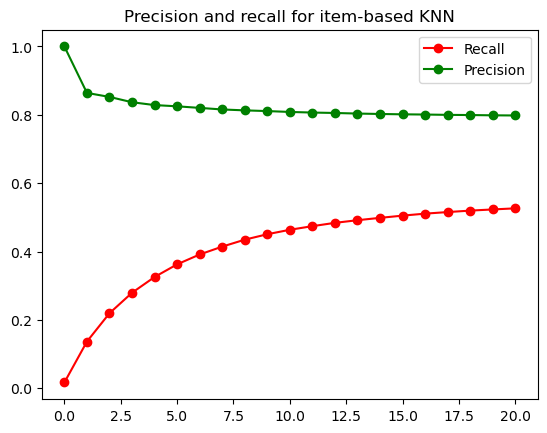

In [20]:
# Compute precision and recall for k between 0 and 20
precision = []
recall = []
for k in range(21):
    # rating > 3.75 = relevant, rating < 3.75 = irrelevant
    precisions, recalls = precision_recall_at_k(predictions, k = k, threshold = 3.75)
    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# Plot
plt.plot(range(21), recall, 'ro-', label="Recall")
plt.plot(range(21), precision, 'go-', label="Precision")
plt.legend()
plt.title("Precision and recall for item-based KNN")
plt.show();

In [21]:
def precision_recall_algo(algo):
    '''Return precision and recall at k metrics for an algorithm.'''    
    
    # Fit algo on training set
    algo.fit(trainset)
    
    # Predict on test set
    predictions = algo.test(testset)
    
    # Compute precision and recall
    precision = []
    recall = []
    for k in range(21):
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
        precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
        recall.append( sum(rec for rec in recalls.values()) / len(recalls) ) 
    
    return precision, recall

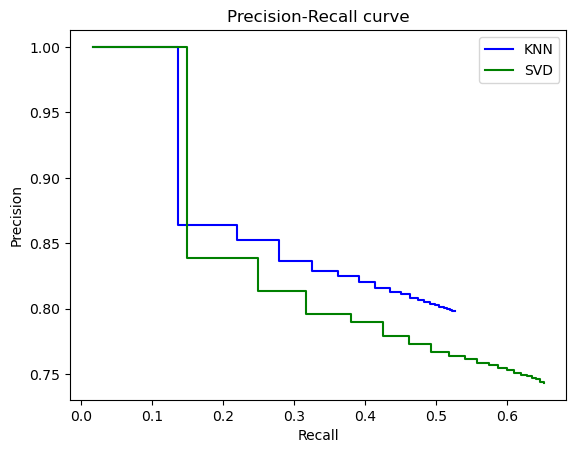

In [22]:
# KNN precision and recall
precision_KNN, recall_KNN = precision_recall_algo(knn_means)

# SVD precision and recall
algo_SVD = SVD()
precision_SVD, recall_SVD = precision_recall_algo(algo_SVD)

# Plot
plt.step(recall, precision, color='b', where='post', label ='KNN')
plt.step(recall_SVD, precision_SVD, color='g', where='post', label ='SVD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve');

Congrats, you are done with the assignment!